# Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## Load data
I started by reading in all the `vehicle` and `non-vehicle` images and put their paths into `data` list.

In [1]:
import glob
import numpy as np
import cv2

vehicles_paths = [
    "./vehicles/GTI_Far/*.png",
    "./vehicles/GTI_Left/*.png",
    "./vehicles/GTI_MiddleClose/*.png",
    "./vehicles/GTI_Right/*.png",
    "./vehicles/KITTI_extracted/*.png"
    ]
non_vehicles_paths = [
    "./non-vehicles/Extras/*.png",
    "./non-vehicles/GTI/*.png"
    ]

# Define a function to load the data from dataset
def load_data_from_paths(v_paths, nv_paths):
    feats_data = []
    labels_data = []
    # Load vehicle images
    for path in v_paths:
        images = glob.glob(path)        
        for name in images:
            feats_data.append(name)
            labels_data.append(0)
    # Load non-vehicle images        
    for path in nv_paths:
        images = glob.glob(path)
        for name in images:
            feats_data.append(name)
            labels_data.append(1) # for non-vehicles
            
    return feats_data, labels_data

data, label = load_data_from_paths(vehicles_paths, non_vehicles_paths)
print("Number of feature images =",len(data))

Number of feature images = 17760


## Histogram of Oriented Gradients (HOG)

### 1. Extracting HOG features from the training images.
In this step I convert the RGB images to grayscale images and calculate the HOG feature of them.
The two pictures shown at the bottom are two example of vehicle and non-vehicle images in data set and their HOG feature images.

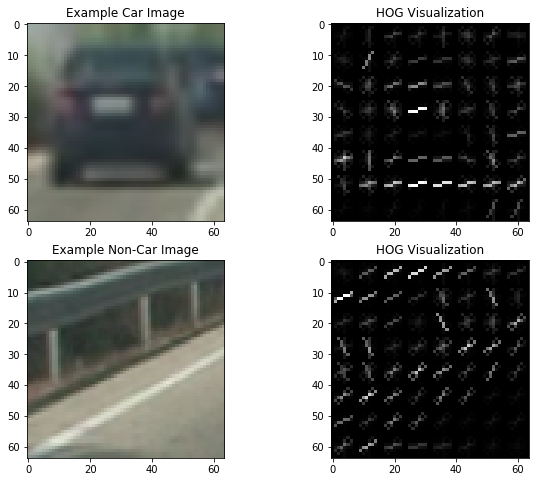

In [37]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.feature import hog
%matplotlib inline

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
# Define a function to extract HOG feature from training image set
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

# Read in the car image
image_v = mpimg.imread(data[0])
image_nv = mpimg.imread(data[len(data)-1])
gray_v = cv2.cvtColor(image_v, cv2.COLOR_RGB2GRAY)
gray_nv = cv2.cvtColor(image_nv, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features_v, hog_image_v = get_hog_features(gray_v, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
features_nv, hog_image_nv = get_hog_features(gray_nv, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

# Plot the examples
plt.figure(figsize=(10,8));
plt.subplot(2,2,1);
plt.imshow(image_v, cmap='gray');
plt.title('Example Car Image');
plt.subplot(2,2,2);
plt.imshow(hog_image_v, cmap='gray');
plt.title('HOG Visualization');
plt.subplot(2,2,3);
plt.imshow(image_nv, cmap='gray');
plt.title('Example Non-Car Image');
plt.subplot(2,2,4);
plt.imshow(hog_image_nv, cmap='gray');
plt.title('HOG Visualization');

### 2. Final choice of HOG parameters
I then explored different color spaces and different `skimage.hog()` parameters (`orientations`, `pixels_per_cell`, and `cells_per_block`).  I grabbed random images from each of the two classes and displayed them to get a feel for what the `skimage.hog()` output looks like.

I tried various combinations of parameters and set the parameters of `colorspace = 'YCrCb'`,`orientations=9`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)`:

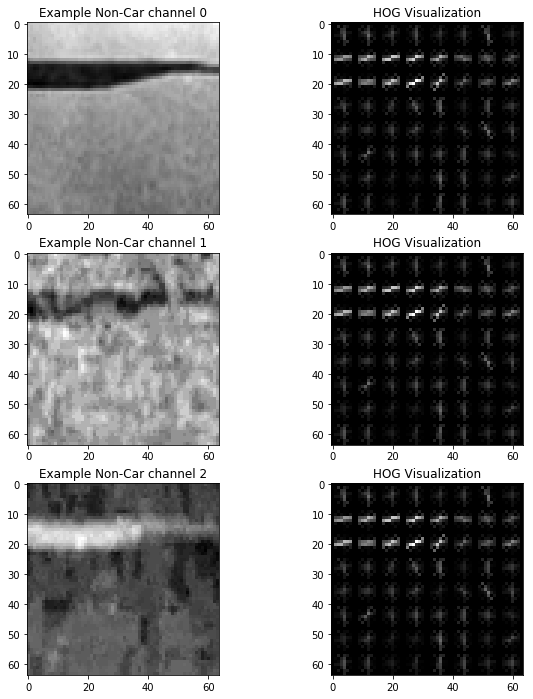

In [7]:
# Define HOG parameters
colorspace = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'

# Generate a random index to look at a car image
ind = np.random.randint(0, len(data))
# Read in the image
image = mpimg.imread(data[ind])
image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
# Call our function with vis=True to see an image output
hog_features = []
hog_images = []
for channel in range(image.shape[2]):
    hog_feature, hog_image = get_hog_features(image[:,:,channel], 
                                              orient, pix_per_cell, cell_per_block, 
                                              vis=True, feature_vec=True)
    hog_features.append(hog_feature)
    hog_images.append(hog_image)
# Plot the examples
plt.figure(figsize=(10,12));
for i in range(image.shape[2]):
    plt.subplot(image.shape[2],2,i*2+1);
    plt.imshow(image[:,:,i], cmap='gray');
    if label[ind] == 0:
        plt.title('Example Car Image channel '+str(i));
    else:
        plt.title('Example Non-Car channel '+str(i));
    plt.subplot(image.shape[2],2,i*2+2);
    plt.imshow(hog_image, cmap='gray');
    plt.title('HOG Visualization');
    


### 3. Train a classifier
I trained a linear SVM using the HOG features.

The HOG feature length is 5292.

I split the dataset to 80% traning set and 20% test set.

The test accuracy of this SVM is 98.28%.

In [10]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
import time

# generate HOG features for all data
colorspace = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'

t=time.time()
data_features = extract_features(data, cspace=colorspace, orient=orient, 
                                 pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Fit a per-column scaler
X_scaler = StandardScaler().fit(data_features)
# Apply the scaler to data_features
scaled_X = X_scaler.transform(data_features)
# Set label to y
y = label
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

62.12 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292
14.43 Seconds to train SVC...
Test Accuracy of SVC =  0.9828
My SVC predicts:  [0 1 0 1 0 1 0 0 0 0]
For these 10 labels:  [0, 1, 0, 1, 0, 1, 0, 0, 0, 0]
0.00167 Seconds to predict 10 labels with SVC


## Sliding Window Search
### 1. Implementation of the sliding window
I search only the lower part of the image to avoid wasting search of sky.

I set the window size to `64X64`, which has the same size of the traning data.

And for the overlap rate, I set it to 50% in both x and y direction.

The picture in the bottom shows the image plotted with all sliding windows.


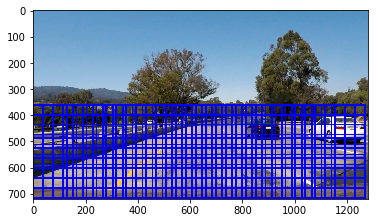

In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

# Read a test image
image = mpimg.imread('./test_images/test1.jpg')

#Define a function to draw rectangle on image
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function that find the window segements in image
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[int(image.shape[0]/2), None], 
                    xy_window=(128, 128), xy_overlap=(0.7, 0.7))
# Draw and plot search boxes on image
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img);

### 2. Pipeline on single image
#### 2.1 Train the classifier
To train the classifier for the final video processing, I take not only HOG features, but also color histogram and spatial binning features.

The new feature length is 8460.

The parameters for HOG feature extraction is same as last section: `colorspace = 'YCrCb'`,`orientations=9`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)`.

I split the data into 80% training set and 20% test set.

The test accuracy of SVM is 99.13%, higher than only use the HOG features.


In [4]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
import time

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract HOG feature from training image set
def extract_combined_features(imgs, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, 
                              spatial_size = (32,32), hist_bins = 32):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Get hog feature
        hog1 = get_hog_features(feature_image[:,:,0], orient, pix_per_cell, cell_per_block, feature_vec=False).ravel()
        hog2 = get_hog_features(feature_image[:,:,1], orient, pix_per_cell, cell_per_block, feature_vec=False).ravel()
        hog3 = get_hog_features(feature_image[:,:,2], orient, pix_per_cell, cell_per_block, feature_vec=False).ravel()
        hog_features = np.hstack((hog1, hog2, hog3))
        # Get color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        hist_features = color_hist(feature_image, nbins=hist_bins)
        # flatten feature vector
        feature = np.hstack((spatial_features, hist_features, hog_features)).ravel()
        features.append(feature)

    # Return list of feature vectors
    return features

# generate HOG features for all data
colorspace = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size = (32,32)
hist_bins = 32

t=time.time()
data_features = extract_combined_features(data, cspace=colorspace, orient=orient, pix_per_cell=pix_per_cell, 
                                          cell_per_block=cell_per_block, spatial_size = spatial_size, 
                                          hist_bins = hist_bins)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

90.84 Seconds to extract features...


In [5]:
# Fit a per-column scaler
X_scaler = StandardScaler().fit(data_features)
# Apply the scaler to data_features
scaled_X = X_scaler.transform(data_features)
# Set label to y
y = label
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
10.13 Seconds to train SVC...
Test Accuracy of SVC =  0.991
My SVC predicts:  [0 0 1 1 1 1 1 0 0 0]
For these 10 labels:  [0, 0, 1, 1, 1, 1, 1, 0, 0, 0]
0.00237 Seconds to predict 10 labels with SVC


In [6]:
import pickle
# save SVM model and scaler
pickle.dump( svc, open( "model.p", "wb" ) )
pickle.dump( X_scaler, open( "scaler.p", "wb" ) )

#### 2.2 Find cars by sliding window
Ultimately I searched on two scales (1.0 and 1.5) using YCrCb 3-channel HOG features plus spatially binned color and histograms of color in the feature vector, which provided a nice result.  

Here are some example images:

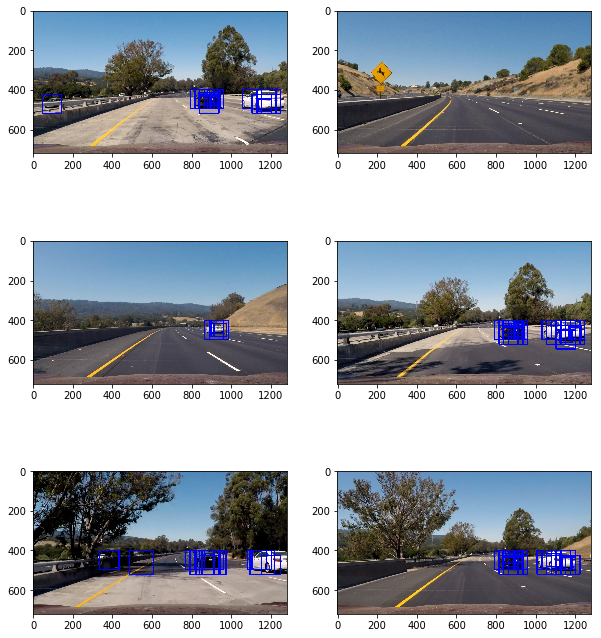

In [7]:
import warnings
warnings.filterwarnings('ignore')

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, 
              orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    box_list = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = np.hstack((spatial_features, hist_features, hog_features)).ravel()
            test_features = X_scaler.transform(test_features)
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 0:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box_list.append(((xbox_left, ystart+ytop_draw), (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return box_list

image1 = mpimg.imread('./test_images/test1.jpg')
image2 = mpimg.imread('./test_images/test2.jpg')
image3 = mpimg.imread('./test_images/test3.jpg')
image4 = mpimg.imread('./test_images/test4.jpg')
image5 = mpimg.imread('./test_images/test5.jpg')
image6 = mpimg.imread('./test_images/test6.jpg')
ystart = 400
ystop = 656
scale1 = 1.5
scale2 = 1
spatial_size = (32,32)
hist_bins = 32

box_list1_1 = find_cars(image1, ystart, ystop, scale1, svc, X_scaler, 
                      orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
box_list1_2 = find_cars(image1, ystart, ystop, scale2, svc, X_scaler, 
                      orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
box_list2_1 = find_cars(image2, ystart, ystop, scale1, svc, X_scaler, 
                      orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
box_list2_2 = find_cars(image2, ystart, ystop, scale2, svc, X_scaler, 
                      orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
box_list3_1 = find_cars(image3, ystart, ystop, scale1, svc, X_scaler, 
                      orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
box_list3_2 = find_cars(image3, ystart, ystop, scale2, svc, X_scaler, 
                      orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
box_list4_1 = find_cars(image4, ystart, ystop, scale1, svc, X_scaler, 
                      orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
box_list4_2 = find_cars(image4, ystart, ystop, scale1, svc, X_scaler, 
                      orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
box_list5_1 = find_cars(image5, ystart, ystop, scale2, svc, X_scaler, 
                      orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
box_list5_2 = find_cars(image5, ystart, ystop, scale1, svc, X_scaler, 
                      orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
box_list6_1 = find_cars(image6, ystart, ystop, scale1, svc, X_scaler, 
                      orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
box_list6_2 = find_cars(image6, ystart, ystop, scale2, svc, X_scaler, 
                      orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
# Plot car boxes on original image
draw_img1 = np.copy(image1)
for box in box_list1_1:
    cv2.rectangle(draw_img1,box[0],box[1],(0,0,255),6) 
for box in box_list1_2:
    cv2.rectangle(draw_img1,box[0],box[1],(0,0,255),6) 
draw_img2 = np.copy(image2)
for box in box_list2_1:
    cv2.rectangle(draw_img2,box[0],box[1],(0,0,255),6) 
for box in box_list2_2:
    cv2.rectangle(draw_img2,box[0],box[1],(0,0,255),6) 
draw_img3 = np.copy(image3)
for box in box_list3_1:
    cv2.rectangle(draw_img3,box[0],box[1],(0,0,255),6) 
for box in box_list3_2:
    cv2.rectangle(draw_img3,box[0],box[1],(0,0,255),6) 
draw_img4 = np.copy(image4)
for box in box_list4_1:
    cv2.rectangle(draw_img4,box[0],box[1],(0,0,255),6) 
for box in box_list4_2:
    cv2.rectangle(draw_img4,box[0],box[1],(0,0,255),6) 
draw_img5 = np.copy(image5)
for box in box_list5_1:
    cv2.rectangle(draw_img5,box[0],box[1],(0,0,255),6) 
for box in box_list5_2:
    cv2.rectangle(draw_img5,box[0],box[1],(0,0,255),6) 
draw_img6 = np.copy(image6)
for box in box_list6_1:
    cv2.rectangle(draw_img6,box[0],box[1],(0,0,255),6) 
for box in box_list6_2:
    cv2.rectangle(draw_img6,box[0],box[1],(0,0,255),6) 
    
plt.figure(figsize=(10,12));
plt.subplot(321);
plt.imshow(draw_img1);
plt.subplot(322);
plt.imshow(draw_img2);
plt.subplot(323);
plt.imshow(draw_img3);
plt.subplot(324);
plt.imshow(draw_img4);
plt.subplot(325);
plt.imshow(draw_img5);
plt.subplot(326);
plt.imshow(draw_img6);

#### 2.3 Multiple detection & False Positive

As you can see the 5th image has some false positive detections and all images have multiple detections of the vehicle.

To solve this problem, I created a heatmap from positive detections and then thresholded that map to identify vehicle positions.  

I then used `scipy.ndimage.measurements.label()` to identify individual blobs in the heatmap.  

I then assumed each blob corresponded to a vehicle.  

I constructed bounding boxes to cover the area of each blob detected. 

Here's an example result showing the heatmap from test image, the result of `scipy.ndimage.measurements.label()` and the bounding boxes then overlaid on the original image:

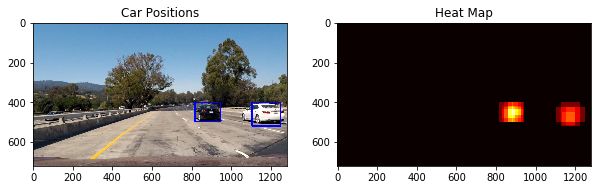

In [10]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = np.zeros_like(image1[:,:,0]).astype(np.float)
heat = add_heat(heat,box_list1_1)
heat = add_heat(heat,box_list1_2)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image1), labels)

#Plot final car image and heat map
plt.figure(figsize=(10,4));
plt.subplot(121);
plt.imshow(draw_img);
plt.title('Car Positions');
plt.subplot(122);
plt.imshow(heatmap, cmap='hot');
plt.title('Heat Map');

## Video Implementation
Here's a link(https://youtu.be/VVyM5_3ErAA) of my final video.

For the final version, I choose to skip 4 frames in every 5 frame, because the car doesn't move too much in short time.

In the git repository there are two other version videos as backlog.

final_video_fyf_1scale.mp4 is processed frame by frame with one scale serach window.

final_video_fyf_1scale.mp4 is processed frame by frame with two scale serach window.

In [17]:
def process_img(img):
    global frame
    global labels
    frame = frame + 1
    if (frame%5 == 1):
        box_list1 = find_cars(img, ystart, ystop, scale1, svc, X_scaler, 
                              orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        box_list2 = find_cars(img, ystart, ystop, scale2, svc, X_scaler, 
                              orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        heat = add_heat(heat,box_list1)
        heat = add_heat(heat,box_list2)
        heat = apply_threshold(heat,1)
        heatmap = np.clip(heat, 0, 255)
        labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

In [18]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import moviepy as mve

global frame
frame = 0
# Video processing
output = 'final_video.mp4'
clip = VideoFileClip("project_video.mp4")
video_clip = clip.fl_image(process_img)
video_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video final_video2.mp4
[MoviePy] Writing video final_video2.mp4



100%|█████████▉| 1260/1261 [05:13<00:00,  3.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: final_video2.mp4 



## Discussion

My SVM training works as following steps:

1. convert image to YCrCb space and extract HOG features for all three channels.

2. extract the color histogram and spatial binning features and combine with HOG features together.

3. Split all image features into training and test set.

4. Adopt LinearSVC for training.

My Video pipeline includes following steps:

1. Skip last 4 frames in every 5 frames and only use first frame for processing and apply the detection lables to rest 4 frames.

2. Use pre-defined search windows with different scales to cut subimages in image frame.

3. For each subimage extract the HOG + color + spatial features

4. Predict vehicle or non-vehicle using SVM

5. create heat map to solve multi detection problem and apply a threshold for false positive

6. used `scipy.ndimage.measurements.label()` to identify individual blobs in the heatmap

7. Plot lables on raw image

To improve the vehicle detection performance, I first apply a multi scale searching on images, because the vehicle scale changes in image with respect to the distance to ego vehicle. Then I found out the frame by frame processing makes the output jittering, so I try to only process the first frame in every 5 frames and use the same detection output to rest 4 frames, which makes my final video more stable.

For the further step, the choices of search windows could be more efficient, the window could be calibrated according to the position of the image instead of a fixed window size. And the tracking method could also be applied.